In [2]:
import pandas as pd
import os

In [3]:
data_folder = '../data/raw'

# Loading the uploaded files to inspect their contents and structure
file_paths = []
file_paths.append( data_folder + "/D08A071.csv")
file_paths.append( data_folder + "/D08A084.csv")
file_paths.append( data_folder + "/D08A115.csv")


# Load CSV files
for file in file_paths:
    data = pd.read_csv(file)
    print(f"File: {file}")
    print(data.head())
    print("\n" + "="*50 + "\n")



File: ../data/raw/D08A071.csv
         saatlik  yagis_toplam  qdeger
0  1/1/2014 0:00           0.0   0.728
1  1/1/2014 1:00           0.0   0.728
2  1/1/2014 2:00           0.0   0.728
3  1/1/2014 3:00           0.0   0.728
4  1/1/2014 4:00           0.0   0.728


File: ../data/raw/D08A084.csv
               saatlik  yagis_toplam  qdeger
0  2016-02-25 05:00:00           0.0   0.011
1  2016-02-25 06:00:00           0.0   0.011
2  2016-02-25 07:00:00           0.0   0.011
3  2016-02-25 08:00:00           0.0   0.011
4  2016-02-25 09:00:00           0.0   0.011


File: ../data/raw/D08A115.csv
               saatlik  yagis_toplam  qdeger
0  2016-02-23 10:00:00           0.0   1.122
1  2016-02-23 11:00:00           0.0   1.122
2  2016-02-23 12:00:00           0.0   1.122
3  2016-02-23 13:00:00           0.0   1.122
4  2016-02-23 14:00:00           0.0   1.122




In [4]:
# Rename columns for consistency and parse the timestamp in each CSV file
def load_and_process_data(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    # Rename columns to 'timestamp' 'precipitation' and 'flow'
    data.columns = ["timestamp", "precipitation", "flow"]
    # Parse the timestamp column to datetime format
    data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce", dayfirst=False)
    # Set the timestamp as the index
    data.set_index("timestamp", inplace=True)
    # Verifique quantidade de valores flow > threshold
    # Resample to hourly frequency and forward-fill missing values
    data = data.resample("h").mean().ffill()
    # Add a flood label based on the threshold
    threshold = data["flow"].quantile(0.92)
    data["flood"] = (data["flow"] > threshold).astype(int)
    return data


# Apply this function to each of the CSV files
data_processed = []
for file in file_paths:
    data_processed.append(load_and_process_data(file))

# Checking the first few rows of the processed data
for i, data in enumerate(data_processed):
    print(f"File {i+1}:")
    print(data.head())
    print("\n" + "="*50 + "\n")


File 1:
                     precipitation   flow  flood
timestamp                                       
2014-01-01 00:00:00            0.0  0.728      0
2014-01-01 01:00:00            0.0  0.728      0
2014-01-01 02:00:00            0.0  0.728      0
2014-01-01 03:00:00            0.0  0.728      0
2014-01-01 04:00:00            0.0  0.728      0


File 2:
                     precipitation   flow  flood
timestamp                                       
2016-02-25 05:00:00            0.0  0.011      0
2016-02-25 06:00:00            0.0  0.011      0
2016-02-25 07:00:00            0.0  0.011      0
2016-02-25 08:00:00            0.0  0.011      0
2016-02-25 09:00:00            0.0  0.011      0


File 3:
                     precipitation   flow  flood
timestamp                                       
2016-02-23 10:00:00            0.0  1.122      0
2016-02-23 11:00:00            0.0  1.122      0
2016-02-23 12:00:00            0.0  1.122      0
2016-02-23 13:00:00            0.0  1.122

In [5]:
# Joining each processed dataset one by one to avoid suffix conflict

# Start with the first dataset and join each subsequent one sequentially
combined_data = data_processed[0].join(data_processed[1], rsuffix='_file2', how='outer').join(
    data_processed[2], rsuffix='_file3', how='outer')

# Rename columns for clarity
combined_data.columns = [
    'precipitation_file1', 'flow_file1', 'flood_file1',
    'precipitation_file2', 'flow_file2', 'flood_file2',
    'precipitation_file3', 'flow_file3', 'flood_file3'
]

# Create a unified flood label where any dataset's flood column indicates a flood (value 1)
combined_data['flood'] = combined_data[
    ['flood_file1', 'flood_file2', 'flood_file3']
].max(axis=1)

# Drop individual flood columns, retaining only the combined flood label
combined_data = combined_data.drop(
    columns=['flood_file1', 'flood_file2', 'flood_file3']
)

# Display the first few rows of the combined dataset
combined_data.head()


,precipitation_file1,flow_file1,precipitation_file2,flow_file2,precipitation_file3,flow_file3,flood
timestamp,,,,,,,
2014-01-01 00:00:00,0.0,0.728,NaN,NaN,NaN,NaN,0.0
2014-01-01 01:00:00,0.0,0.728,NaN,NaN,NaN,NaN,0.0
2014-01-01 02:00:00,0.0,0.728,NaN,NaN,NaN,NaN,0.0
2014-01-01 03:00:00,0.0,0.728,NaN,NaN,NaN,NaN,0.0
2014-01-01 04:00:00,0.0,0.728,NaN,NaN,NaN,NaN,0.0


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Filling NaN values with 0 (assuming missing data represents no observed value in those sensors)
combined_data_filled = combined_data.fillna(0)

# Separate features and target for scaling
X = combined_data_filled.drop(columns=['flood'])
y = combined_data_filled['flood']

# Scale features to [0, 1] range using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame for clarity
X_scaled_df = pd.DataFrame(X_scaled, index=combined_data_filled.index, columns=X.columns)
X_scaled_df['flood'] = y  # Add the target column back

# Display the first few rows of the scaled and normalized dataset
X_scaled_df.head()


,precipitation_file1,flow_file1,precipitation_file2,flow_file2,precipitation_file3,flow_file3,flood
timestamp,,,,,,,
2014-01-01 00:00:00,0.0,0.002138,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,0.0,0.002138,0.0,0.0,0.0,0.0,0.0
2014-01-01 02:00:00,0.0,0.002138,0.0,0.0,0.0,0.0,0.0
2014-01-01 03:00:00,0.0,0.002138,0.0,0.0,0.0,0.0,0.0
2014-01-01 04:00:00,0.0,0.002138,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = X_scaled_df.drop(columns=['flood'])
y = X_scaled_df['flood']

# Splitting into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())
# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

flood
0.0    57516
1.0     9986
Name: count, dtype: int64
flood
0.0    24650
1.0     4280
Name: count, dtype: int64


((67502, 6), (28930, 6), (67502,), (28930,))

In [8]:
X_train.head()

,precipitation_file1,flow_file1,precipitation_file2,flow_file2,precipitation_file3,flow_file3
timestamp,,,,,,
2022-06-02 15:00:00,0.0,0.000330,0.000437,0.000049,0.0,0.022613
2015-02-02 08:00:00,0.0,0.009676,0.000000,0.000000,0.0,0.000000
2018-03-04 02:00:00,0.0,0.001290,0.000000,0.004912,0.0,0.041416
2016-08-03 06:00:00,0.0,0.001290,0.000000,0.000000,0.0,0.007973
2018-03-29 08:00:00,0.0,0.001290,0.000000,0.000982,0.0,0.030648


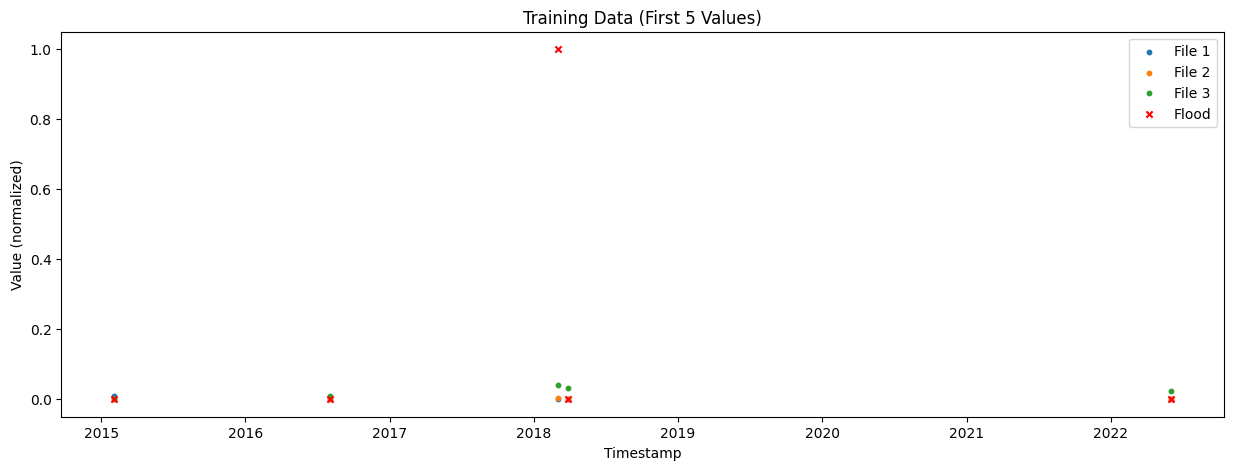

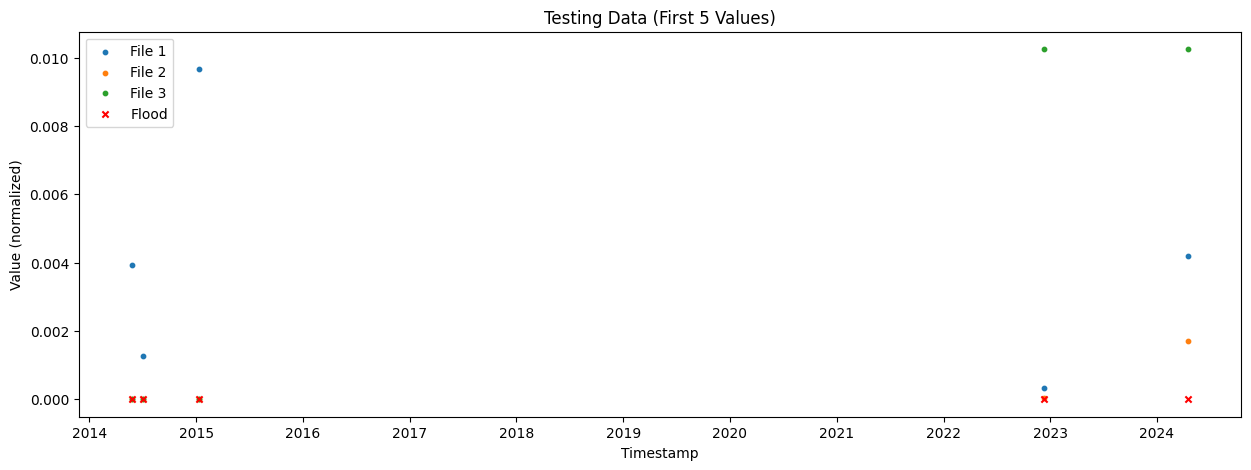

In [18]:
import matplotlib.pyplot as plt

def visualize_time_series(df, title):
  plt.figure(figsize=(15, 5))
  plt.scatter(df.index, df['flow_file1'], label='File 1', s=10)
  plt.scatter(df.index, df['flow_file2'], label='File 2', s=10)
  plt.scatter(df.index, df['flow_file3'], label='File 3', s=10)
  plt.scatter(df.index, df['flood'], label='Flood', color='red', marker='x', s=20)
  plt.title(title)
  plt.xlabel('Timestamp')
  plt.ylabel('Value (normalized)')
  plt.legend()
  plt.show()

# Visualize the first 5 consequent values and the label for training data
visualize_time_series(X_train.join(y_train).iloc[:5], 'Training Data (First 5 Values)')


# Visualize the first 5 consequent values and the label for testing data
visualize_time_series(X_test.join(y_test).iloc[:5], 'Testing Data (First 5 Values)')

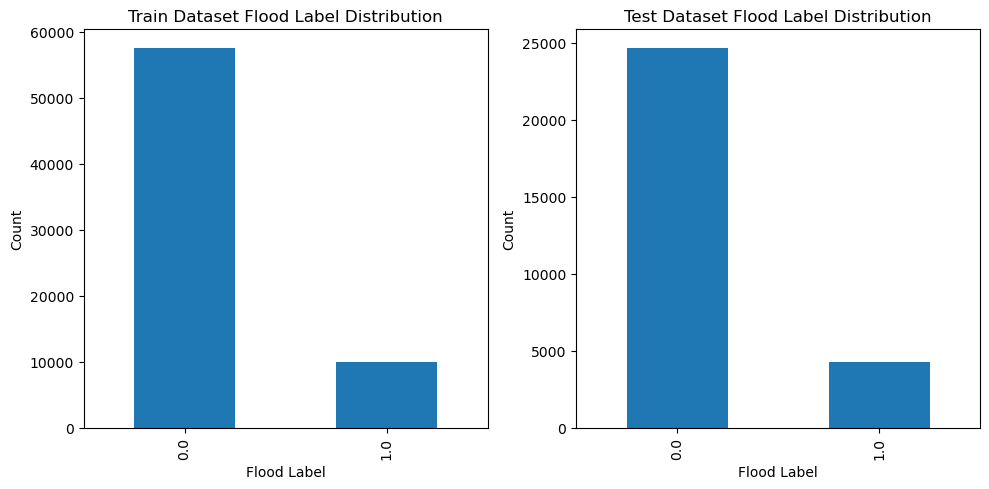

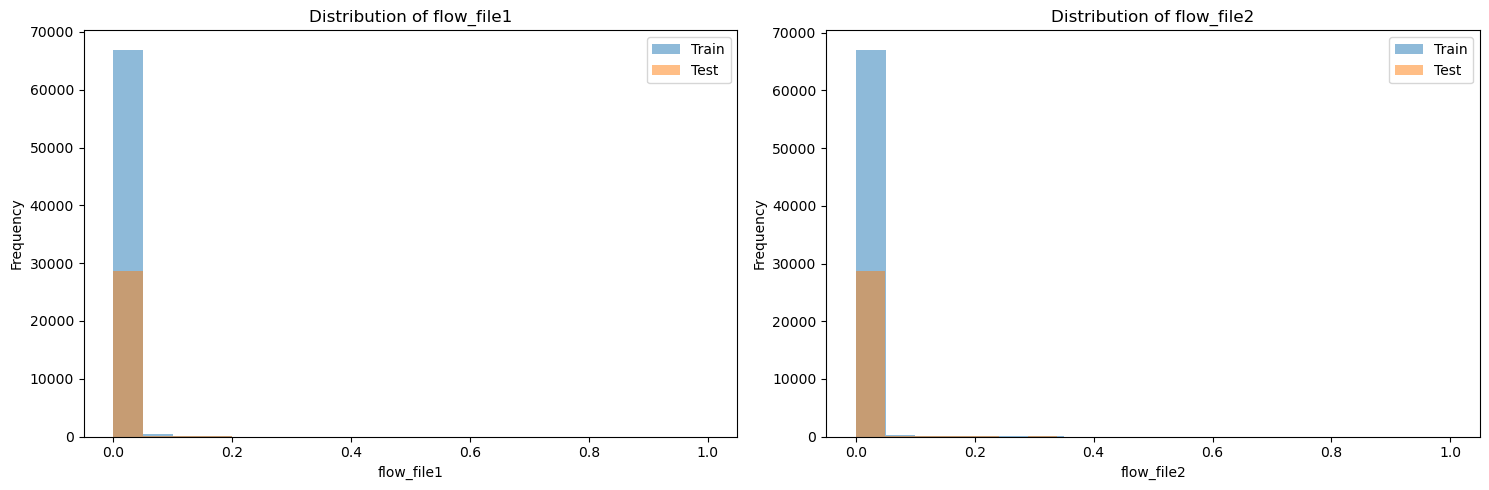

In [9]:
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are defined in the previous cell
# Visualize the distribution of the target variable in both training and test sets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Dataset Flood Label Distribution')
plt.xlabel('Flood Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Dataset Flood Label Distribution')
plt.xlabel('Flood Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Visualize the distribution of a few features in both training and test sets (replace 'value_file1', 'value_file2' with desired features)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(X_train['flow_file1'], bins=20, alpha=0.5, label='Train')
plt.hist(X_test['flow_file1'], bins=20, alpha=0.5, label='Test')
plt.xlabel('flow_file1')
plt.ylabel('Frequency')
plt.title('Distribution of flow_file1')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(X_train['flow_file2'], bins=20, alpha=0.5, label='Train')
plt.hist(X_test['flow_file2'], bins=20, alpha=0.5, label='Test')
plt.xlabel('flow_file2')
plt.ylabel('Frequency')
plt.title('Distribution of flow_file2')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prepare data: separate features and target
X = X_scaled_df.drop(columns=['flood']).values  # convert to numpy array immediately
y = X_scaled_df['flood'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Reshape input data for LSTM: [samples, time steps, features]
# Here time steps=1 because every sample is considered independent here
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define and compile the LSTM model
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks = [early_stop])

# Predict and threshold to binary outputs
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Report results
print(f"LSTM Accuracy: {accuracy:.4f}")
print(f"LSTM Precision: {precision:.4f}")
print(f"LSTM Recall: {recall:.4f}")
print("LSTM Confusion Matrix:")
print(conf_matrix)


Epoch 1/50


c:\Users\caioa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1929/1929 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8797 - loss: 0.3264 - val_accuracy: 0.9110 - val_loss: 0.2150
Epoch 2/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9398 - loss: 0.1546 - val_accuracy: 0.9656 - val_loss: 0.1155
Epoch 3/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9666 - loss: 0.1001 - val_accuracy: 0.9721 - val_loss: 0.0840
Epoch 4/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9713 - loss: 0.0819 - val_accuracy: 0.9739 - val_loss: 0.0703
Epoch 5/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9737 - loss: 0.0721 - val_accuracy: 0.9757 - val_loss: 0.0621
Epoch 6/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9749 - loss: 0.0665 - val_accuracy: 0.9785 - val_loss: 0.0578
Epoch 7/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9764 - loss: 0.0635 - val_accuracy: 0.9802 - val_loss: 0.0556
Epoch 8/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9756 - loss: 0.0618 - val